# データセットの読み込み
以下は、TorchVision からFashion-MNISTデータセットを読み込む方法の例です。  
Fashion-MNIST は、60,000 のトレーニング例と 10,000 のテスト例で構成される Zalando の記事画像のデータセットです。  
各例は、28×28 のグレースケール画像と、10 クラスの 1 つからの関連ラベルで構成されています。

次のパラメータを使用してFashionMNIST データセットを読み込みます。  

- rootトレーニング/テストデータが保存されるパスです。
- trainトレーニングデータセットまたはテストデータセットを指定します。
- download=Trueデータが利用できない場合はインターネットからダウンロードしますroot。
- transformtarget_transform特徴とラベルの変換を指定する

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 26421880/26421880 [00:05<00:00, 5067773.27it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 90956.29it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:02<00:00, 1810122.06it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 597230.65it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



# データセットの反復と視覚化
Datasetsリストのように手動でインデックスを作成できます: 。  
トレーニング データ内のいくつかのサンプルを視覚化するためにtraining_data[index]使用します。matplotlib

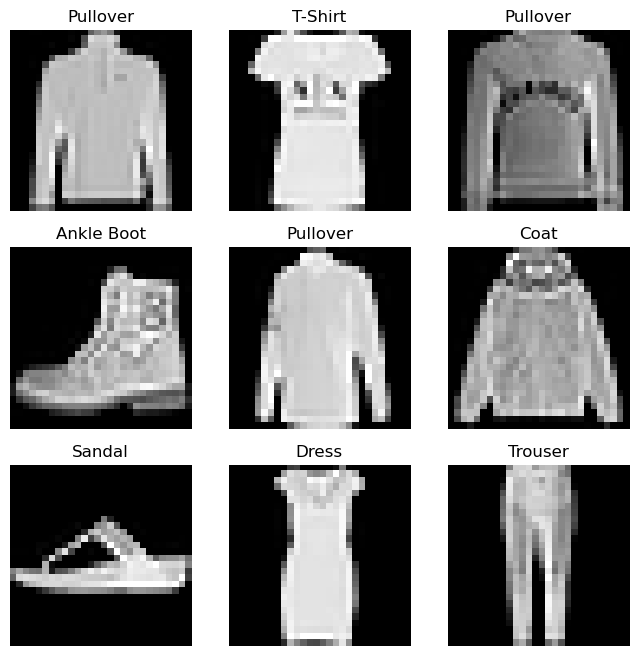

In [2]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

# ファイル用のカスタムデータセットを作成する
カスタム Dataset クラスは、__init__、__len__、__getitem__の 3 つの関数を実装する必要があります。  
この実装を見ると、FashionMNIST 画像はディレクトリに保存されimg_dir、ラベルは CSV ファイルに個別に保存されていますannotations_file。

次のセクションでは、これらの各機能で何が起こっているかを詳しく説明します。

In [5]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

# DataLoaders を使用したトレーニング用データの準備
データセットの特徴を取得Datasetし、一度に 1 つのサンプルにラベルを付けます。  
モデルをトレーニングする際は、通常、サンプルを「ミニバッチ」で渡し、エポックごとにデータを再シャッフルしてモデルのオーバーフィッティングを減らし、Python を使用してmultiprocessingデータ取得を高速化します。

DataLoaderは、この複雑さを簡単な API で抽象化する反復可能オブジェクトです。

In [4]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

# DataLoaderを反復処理する
そのデータセットを にロードしてDataLoader、必要に応じてデータセットを反復処理できます。  
以下の各反復処理では、train_featuresとのバッチtrain_labels(batch_size=64それぞれ特徴とラベルを含む) が返されます。  
 を指定したのでshuffle=True、すべてのバッチを反復処理した後、データがシャッフルされます (データのロード順序をより細かく制御するには、Samplersを参照してください)。

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


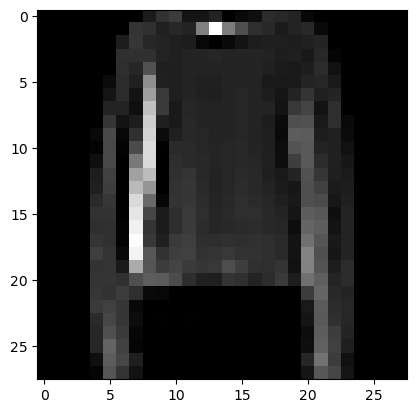

Label: 2


In [6]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")